In [1]:
import numpy as np
import astropy.units as u
from astropy.io import fits
from matplotlib.colors import LogNorm
from matplotlib.patches import Rectangle, Circle
from pathlib import Path
from IPython.display import clear_output
from importlib import reload
from scipy.optimize import minimize

import poppy
import logging, sys
poppy_log = logging.getLogger('poppy')
poppy_log.setLevel('DEBUG')
logging.basicConfig(stream=sys.stdout, level=logging.INFO)
poppy_log.disabled = True

import warnings
warnings.filterwarnings("ignore")

import apra_pop_models
from apra_pop_models.math_module import xp, xcipy, ensure_np_array
import apra_pop_models.fresnel_2dm as fresnel
import apra_pop_models.fraunhofer_2dm as fraunhofer
import apra_pop_models.dm as dm
import apra_pop_models.utils as utils
import apra_pop_models.props as props
from apra_pop_models.imshows import imshow1, imshow2, imshow3
import apra_pop_models.aefc_2dm as aefc


/home/apra/miniconda3/envs/gpu311env/lib/python3.11/site-packages/cupyx/jit/_interface.py:173: FutureWarning: cupyx.jit.rawkernel is experimental. The interface can change in the future.
  cupy._util.experimental('cupyx.jit.rawkernel')


/home/apra/Projects/apra-howfsc-models/apra_pop_models


/home/apra/Projects/apra-howfsc-models/apra_pop_models


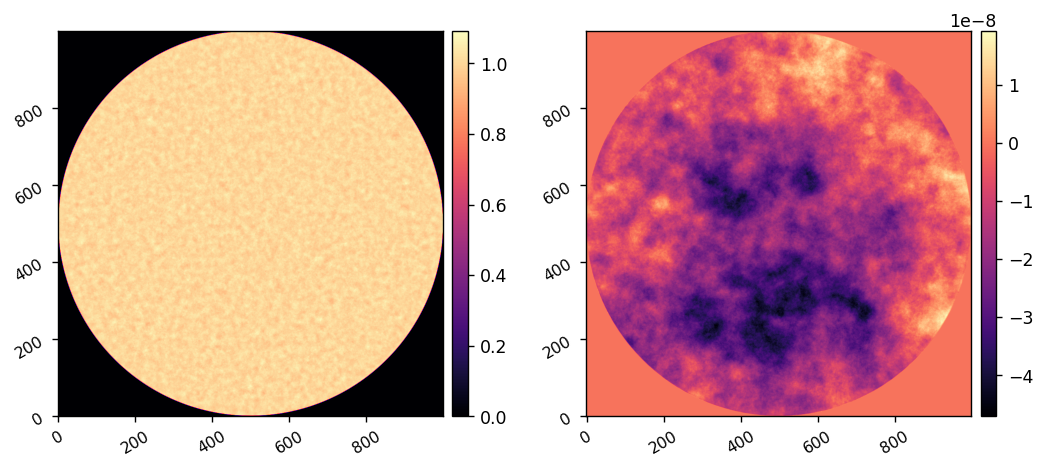

In [2]:
reload(fresnel)
Nact = 34
npsf = 128

I = fresnel.CORO(
    Nact=Nact,
    npsf=npsf,
)
I.use_opds = True

AMP, OPD = I.calc_pupil()
imshow2(AMP, OPD)

/home/apra/Projects/apra-howfsc-models/apra_pop_models


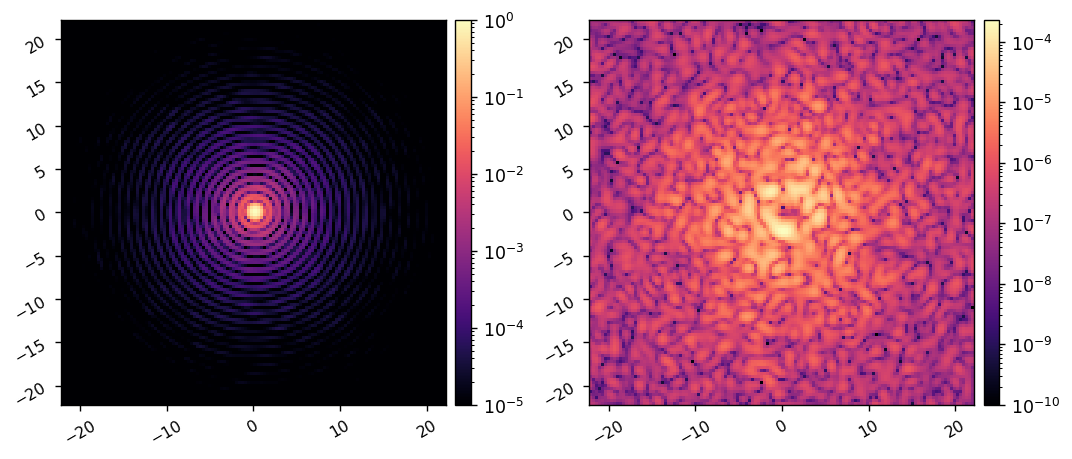

In [3]:
reload(fresnel)

I.use_vortex = False
ref_psf = I.snap()
I.Imax_ref = xp.max(ref_psf)
ref_psf /= I.Imax_ref

I.use_vortex = True
ref_coro_im = I.snap()

imshow2(ref_psf, ref_coro_im,
        pxscl=I.psf_pixelscale_lamDc, lognorm=True, vmin1=1e-5, vmin2=1e-10)


(2048, 2048)
(2048, 2048)


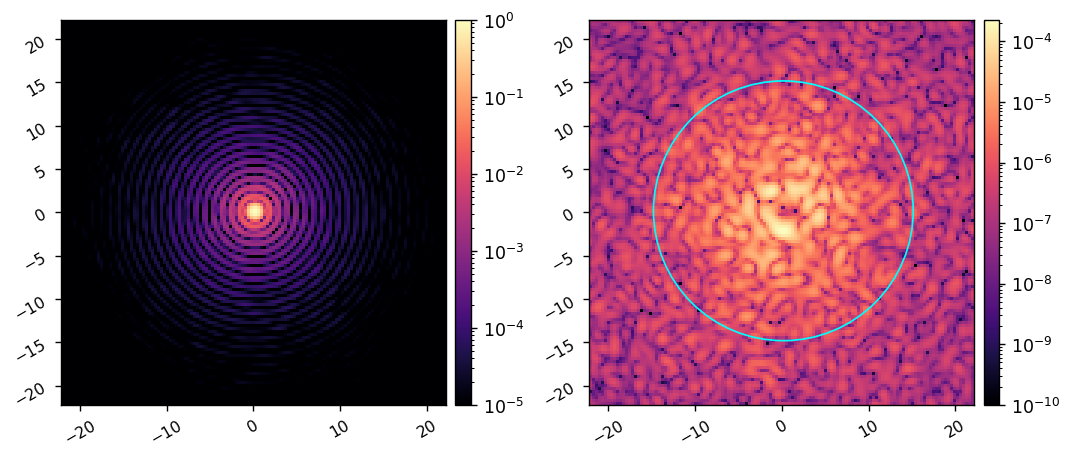

In [8]:
reload(fraunhofer)
reload(props)

M = fraunhofer.MODEL(
    Nact=Nact,
    npsf=npsf,
)
M.AMP = AMP
M.OPD = OPD

M.flip_dm = True
M.flip_lyot = True

acts = xp.zeros(M.Nacts)

model_psf = xp.abs( M.forward(acts, M.wavelength_c, use_vortex=0) )**2
M.setattr('Imax_ref', xp.max(model_psf))
model_psf /= M.Imax_ref

model_coro_im = xp.abs( M.forward(acts, M.wavelength_c, use_vortex=1) )**2

imshow2(
    model_psf, model_coro_im,
    pxscl=M.psf_pixelscale_lamDc, 
    lognorm=True, vmin1=1e-5, vmin2=1e-10,
    patches2=[Circle((M.psf_pixelscale_lamDc/2,M.psf_pixelscale_lamDc/2), M.control_rad, fill=False, color='cyan')]
)

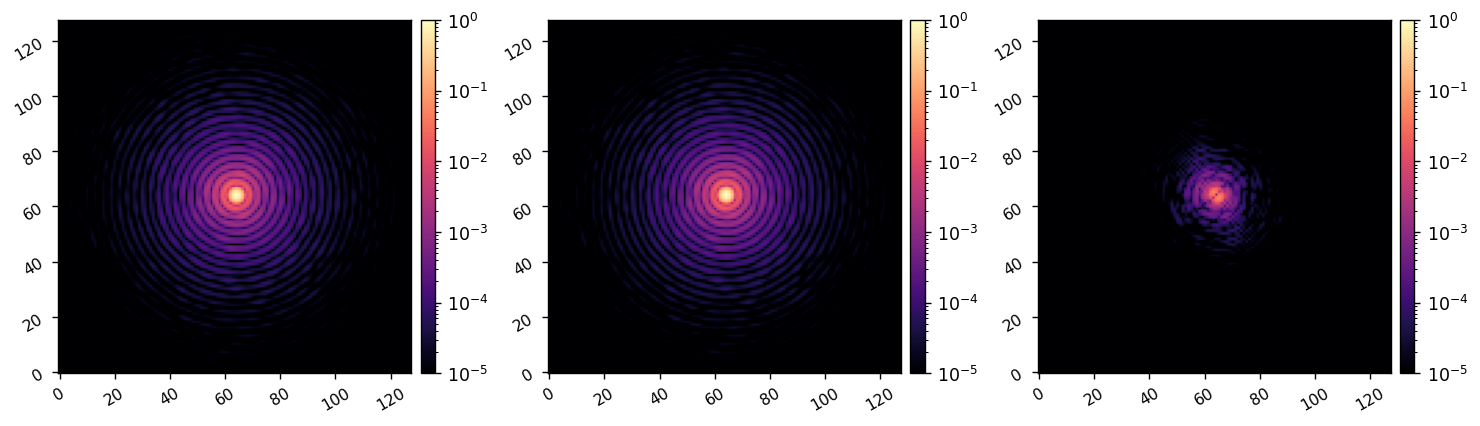

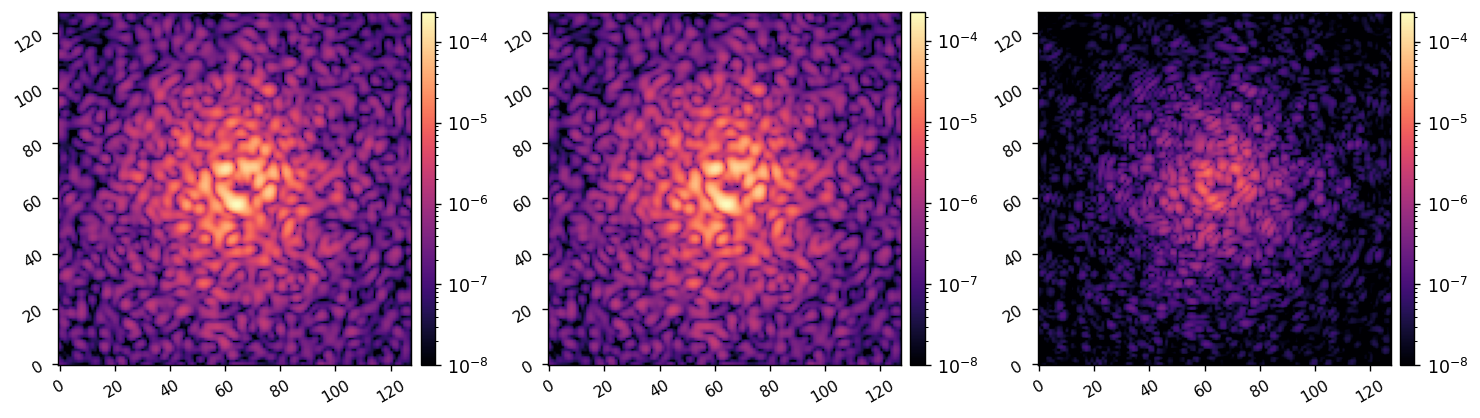

In [9]:
imshow3(ref_psf, model_psf, xp.abs(ref_psf - model_psf), 
        lognorm1=True, lognorm2=True, lognorm3=True, vmax3=1, 
        vmin1=1e-5, vmin2=1e-5, vmin3=1e-5)

imshow3(ref_coro_im, model_coro_im, xp.abs(ref_coro_im - model_coro_im), 
        lognorm1=True, lognorm2=True, lognorm3=True, vmax3=xp.max(ref_coro_im), 
        vmin1=1e-8, vmin2=1e-8, vmin3=1e-8)

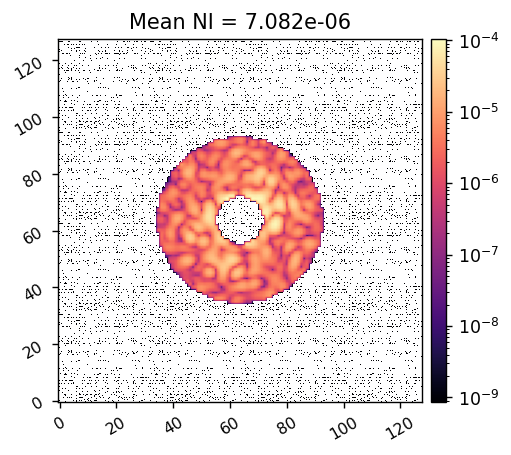

In [10]:
reload(utils)
I.zero_dms()
iwa = 3
owa = 10
rot = 0
control_mask = utils.create_annular_focal_plane_mask(I.npsf, I.psf_pixelscale_lamDc, irad=iwa, orad=owa, edge=None, rotation=rot)
mean_ni = xp.mean(ref_coro_im[control_mask])

imshow1(ref_coro_im*control_mask, f'Mean NI = {mean_ni:.3e}', lognorm=True)


(2048, 2048)
(2048, 2048)
	Cost-function J_delE: 0.017
	Cost-function J_c: 0.000
	Cost-function normalization factor: 0.017
	Total cost-function value: 1.000



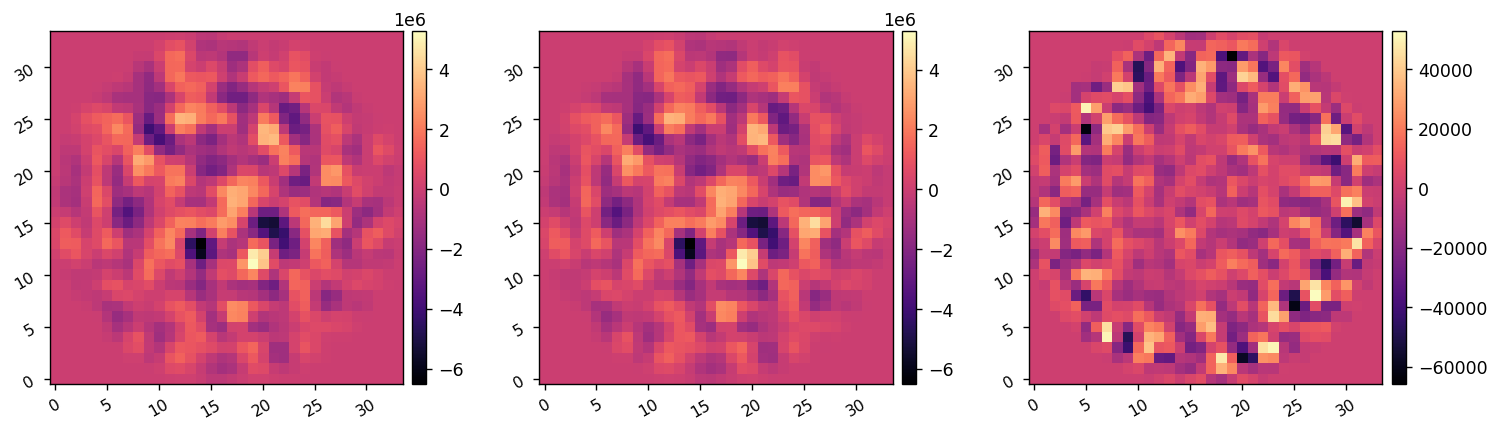

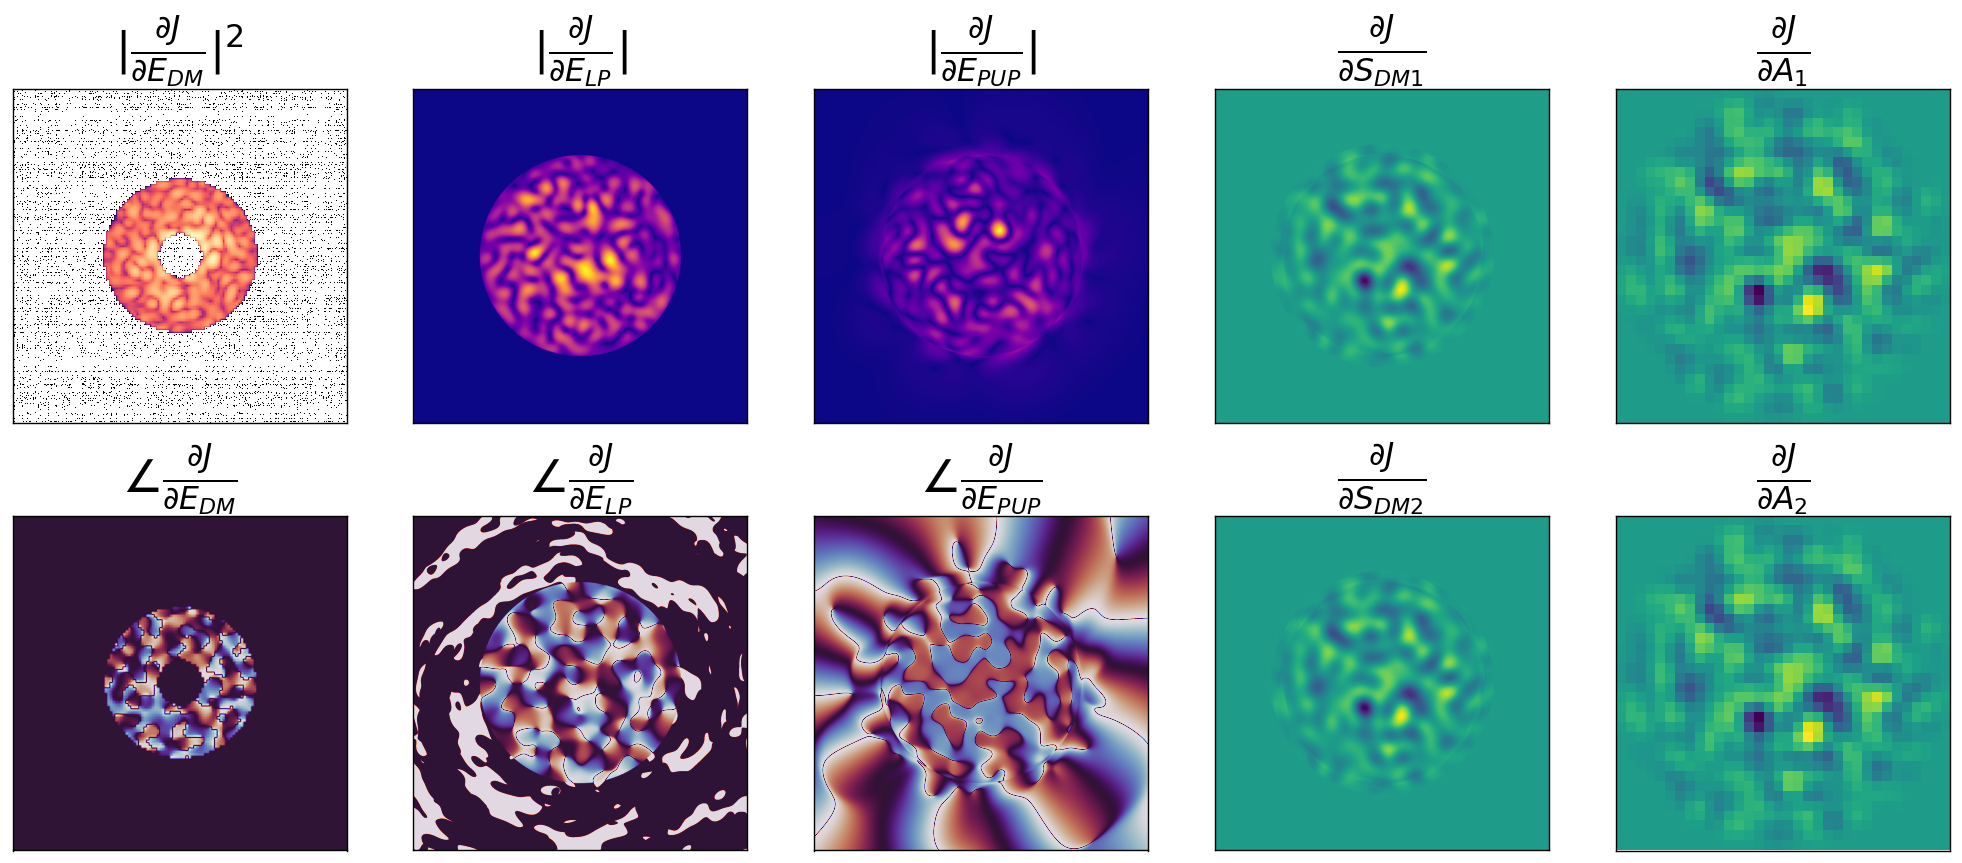

In [11]:
reload(fraunhofer)
current_acts = xp.zeros(M.Nacts)
# current_acts = fits.getdata('example-data/ad_test_acts.fits')

I.set_dm1(fraunhofer.acts_to_command(current_acts[:M.Nacts//2], M.dm_mask))
I.set_dm2(fraunhofer.acts_to_command(current_acts[M.Nacts//2:], M.dm_mask))
E_ab = I.calc_wf() * control_mask

E_FP_nom, E_EP, E_DM2P, DM1_PHASOR, DM2_PHASOR = M.forward(
    current_acts, 
    I.wavelength, 
    use_vortex=True, 
    return_ints=True,
)

rmad_vars = { 
    'current_acts':current_acts,
    'E_ab':E_ab, 
    'E_FP_NOM':E_FP_nom,
    'E_EP':E_EP,
    'E_DM2P':E_DM2P,
    'DM1_PHASOR':DM1_PHASOR,
    'DM2_PHASOR':DM2_PHASOR,
    'control_mask':control_mask,
    'wavelength':I.wavelength,
    'r_cond':1e-3,
}

del_acts = np.zeros(M.Nacts)
J, dJ_dA = fraunhofer.val_and_grad(
    del_acts, 
    M, 
    rmad_vars,
    verbose=True, 
    # plot=True, 
    fancy_plot=True,
)

dm1_grad = fraunhofer.acts_to_command(dJ_dA[:M.Nacts//2], M.dm_mask)
dm2_grad = fraunhofer.acts_to_command(dJ_dA[M.Nacts//2:], M.dm_mask)
imshow3(dm1_grad, dm2_grad, dm2_grad-dm1_grad)

In [12]:
reload(fraunhofer)

current_acts = xp.zeros(M.Nacts)
# current_acts = fits.getdata('example-data/ad_test_acts.fits')

I.set_dm1(fraunhofer.acts_to_command(current_acts[:M.Nacts//2], M.dm_mask))
I.set_dm2(fraunhofer.acts_to_command(current_acts[M.Nacts//2:], M.dm_mask))
E_ab = I.calc_wf() * control_mask
E_FP_nom, E_EP, E_DM2P, DM1_PHASOR, DM2_PHASOR = M.forward(current_acts, I.wavelength, use_vortex=True, return_ints=True,)

rmad_vars = { 
    'current_acts':current_acts,
    'E_ab':E_ab, 
    'E_FP_NOM':E_FP_nom,
    'E_EP':E_EP,
    'E_DM2P':E_DM2P,
    'DM1_PHASOR':DM1_PHASOR,
    'DM2_PHASOR':DM2_PHASOR,
    'control_mask':control_mask,
    'wavelength':I.wavelength,
    'r_cond':1e-3,
}

bfgs_tol = 1e-3
bfgs_opts = {
    'disp':True,
    # 'maxls':50,
    # 'ftol':1e-6,
    # 'gtol':1e-6,
}

del_acts0 = np.zeros(M.Nacts)
res = minimize(
    fraunhofer.val_and_grad, 
    jac=True, 
    x0=del_acts0,
    args=(M, rmad_vars, True, False), 
    method='L-BFGS-B',
    tol=bfgs_tol,
    options=bfgs_opts,
)


(2048, 2048)
(2048, 2048)
	Cost-function J_delE: 0.017
	Cost-function J_c: 0.000
	Cost-function normalization factor: 0.017
	Total cost-function value: 1.000



 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         1904     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.00000D+00    |proj g|=  6.52535D+06
(2048, 2048)
	Cost-function J_delE: 0.003
	Cost-function J_c: 2366863905.325
	Cost-function normalization factor: 0.017
	Total cost-function value: 141127354009.222

(2048, 2048)
	Cost-function J_delE: 0.026
	Cost-function J_c: 10.590
	Cost-function normalization factor: 0.017
	Total cost-function value: 633.027

(2048, 2048)
	Cost-function J_delE: 0.119
	Cost-function J_c: 0.607
	Cost-function normalization factor: 0.017
	Total cost-function value: 43.326

(2048, 2048)
	Cost-function J_delE: 1.064
	Cost-function J_c: 0.050
	Cost-function normalization factor: 0.017
	Total cost-function value: 66.425

(2048, 2048)
	Cost-function J_delE: 4.655
	Cost-function J_c: 0.002
	Cost-function normalization factor: 0.017
	Total cost-function value: 277.700

(2048, 2048)
	

7.0823989956300765e-06 5.763194952008505e-08


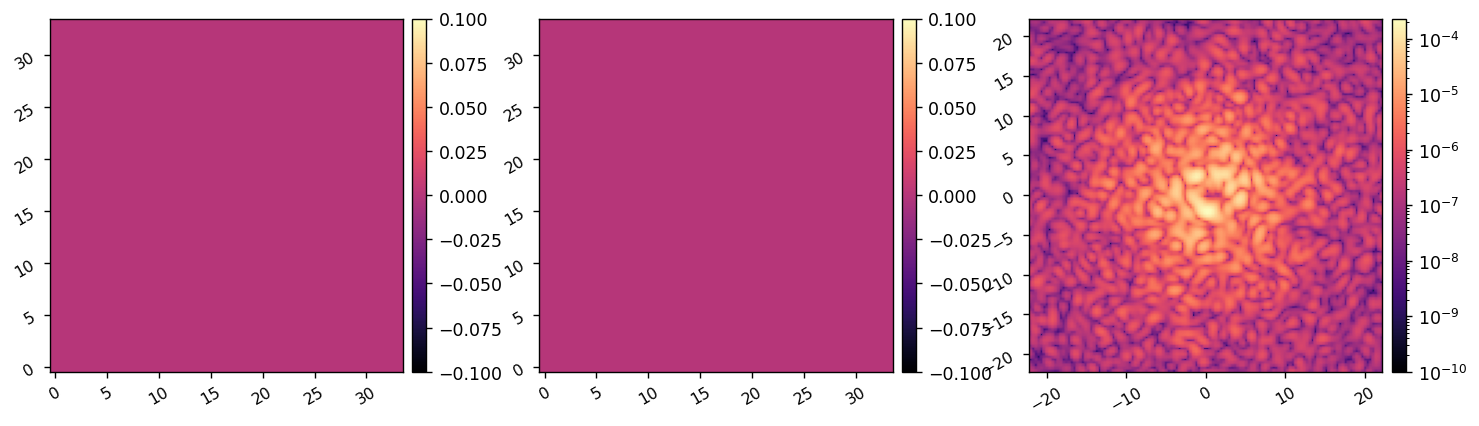

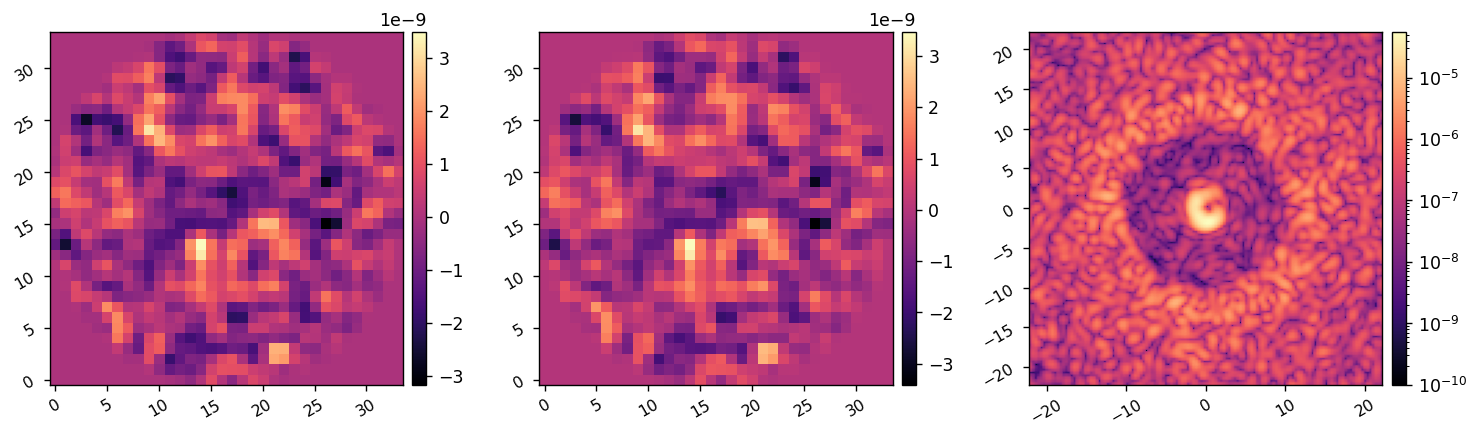

In [13]:
old_dm1 = fraunhofer.acts_to_command(current_acts[:M.Nacts//2], I.dm_mask)
old_dm2 = fraunhofer.acts_to_command(current_acts[M.Nacts//2:], I.dm_mask)
del_dm1 = fraunhofer.acts_to_command(res.x[:M.Nacts//2], I.dm_mask)
del_dm2 = fraunhofer.acts_to_command(res.x[M.Nacts//2:], I.dm_mask)

I.set_dm1(old_dm1)
I.set_dm2(old_dm2)
old_im = I.snap()

I.set_dm1(old_dm1 + del_dm1)
I.set_dm2(old_dm2 + del_dm2)
new_im = I.snap()

print(xp.mean(old_im[control_mask]), xp.mean(new_im[control_mask]))
imshow3(old_dm1, old_dm2, old_im, lognorm3=True, pxscl3=I.psf_pixelscale_lamDc, vmin3=1e-10,)
imshow3(del_dm1, del_dm2, new_im, lognorm3=True, pxscl3=I.psf_pixelscale_lamDc, vmin3=1e-10,)

In [18]:
utils.save_fits('ad_test_acts.fits', res.x)

Saved data to:  ad_test_acts.fits


In [14]:
I.zero_dms()
data = {
    # 'ref_im':ref_coro_im, 
    'images':[ref_coro_im],
    'efields':[],
    'dm1_commands':[],
    'del_dm1_commands':[],
    'dm2_commands':[],
    'del_dm2_commands':[],
    'reg_conds':[],
    'bfgs_tols':[],
    'pixelscale':I.psf_pixelscale_lamDc,
    'control_mask':control_mask, 
}

Computing E-field with model ...
Computing EFC command with L-BFGS
(2048, 2048)
(2048, 2048)


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         1904     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.00000D+00    |proj g|=  8.43972D+07
(2048, 2048)
(2048, 2048)
(2048, 2048)

At iterate    1    f=  9.86489D-01    |proj g|=  5.80852D+07
(2048, 2048)

At iterate    2    f=  9.77996D-01    |proj g|=  4.39940D+07
(2048, 2048)

At iterate    3    f=  9.67039D-01    |proj g|=  4.11778D+07
(2048, 2048)

At iterate    4    f=  9.62235D-01    |proj g|=  7.01475D+07
(2048, 2048)

At iterate    5    f=  9.56465D-01    |proj g|=  3.29478D+07
(2048, 2048)

At iterate    6    f=  9.50516D-01    |proj g|=  2.62553D+07
(2048, 2048)

At iterate    7    f=  9.45436D-01    |proj g|=  2.92013D+07
(2048, 2048)

At iterate    8    f=  9.36440D-01    |proj g|=  6.24913D+07
(2048, 2048)

At iterate    9    f=  9.32854D-01    |proj g|=  8.93398D+07
(2048, 2048)

At iterate   10    f=  9.24762D-01    |proj g|=  2.47717

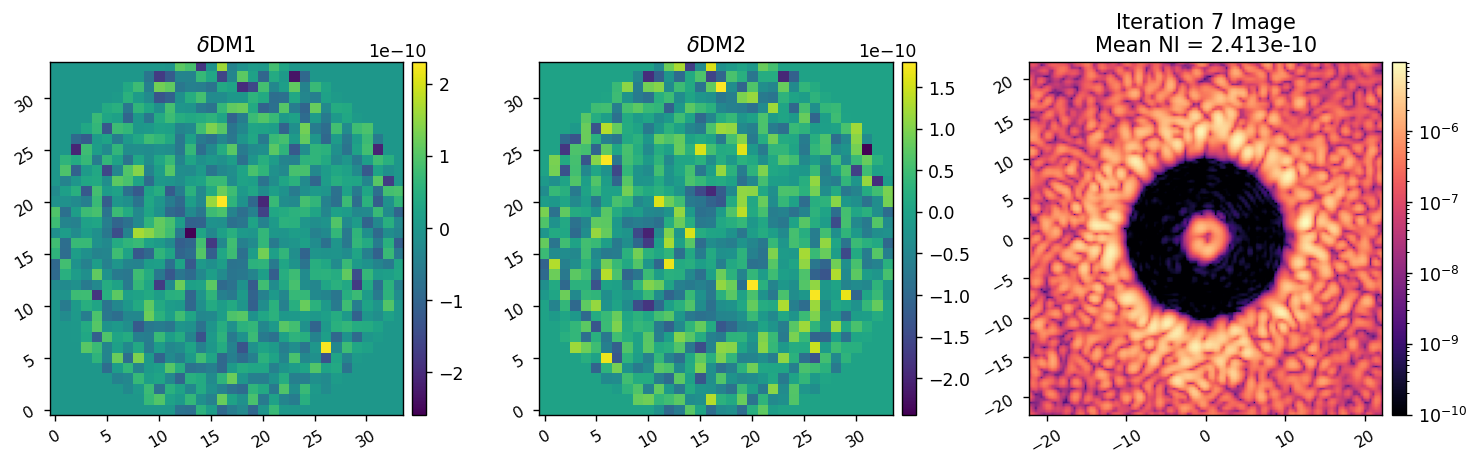

Computing E-field with model ...
Computing EFC command with L-BFGS
(2048, 2048)
(2048, 2048)


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         1904     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.00000D+00    |proj g|=  1.27042D+08
(2048, 2048)
(2048, 2048)
(2048, 2048)

At iterate    1    f=  9.90623D-01    |proj g|=  4.72494D+07
(2048, 2048)

At iterate    2    f=  9.87454D-01    |proj g|=  3.69679D+07
(2048, 2048)

At iterate    3    f=  9.81415D-01    |proj g|=  3.14580D+07
(2048, 2048)

At iterate    4    f=  9.78757D-01    |proj g|=  5.04052D+07
(2048, 2048)

At iterate    5    f=  9.75717D-01    |proj g|=  2.04690D+07
(2048, 2048)

At iterate    6    f=  9.73725D-01    |proj g|=  2.12567D+07
(2048, 2048)

At iterate    7    f=  9.71681D-01    |proj g|=  2.18609D+07
(2048, 2048)

At iterate    8    f=  9.69221D-01    |proj g|=  4.41234D+07
(2048, 2048)

At iterate    9    f=  9.66435D-01    |proj g|=  2.57388D+07
(2048, 2048)

At iterate   10    f=  9.64254D-01    |proj g|=  2.53153

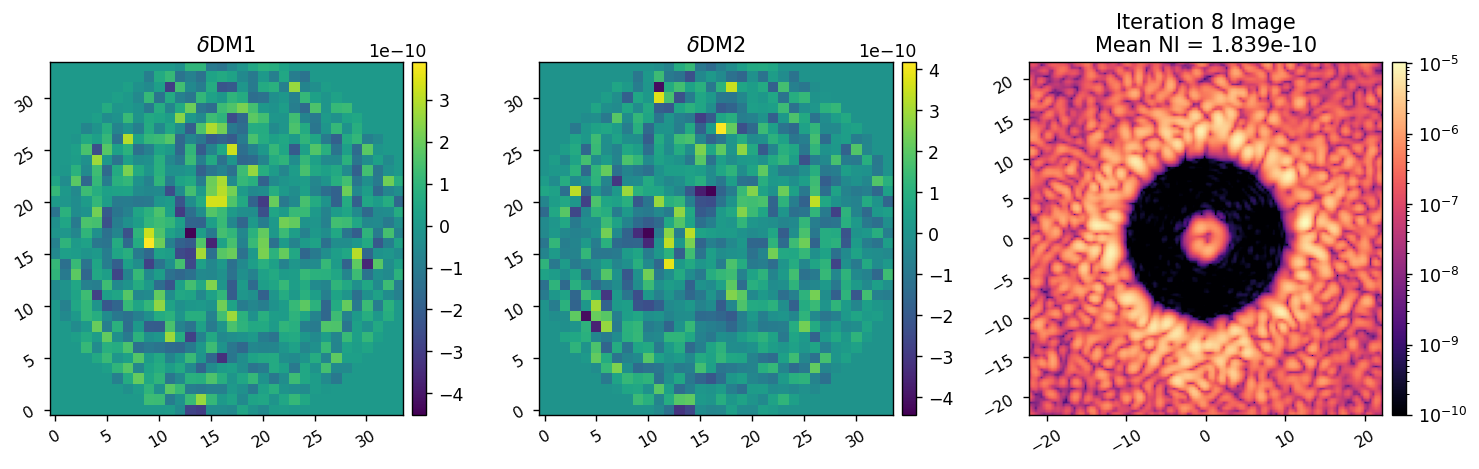

Computing E-field with model ...
Computing EFC command with L-BFGS
(2048, 2048)
(2048, 2048)
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         1904     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.00000D+00    |proj g|=  9.40516D+07
(2048, 2048)


 This problem is unconstrained.


(2048, 2048)
(2048, 2048)

At iterate    1    f=  9.89335D-01    |proj g|=  5.26181D+07
(2048, 2048)

At iterate    2    f=  9.83954D-01    |proj g|=  4.01769D+07
(2048, 2048)

At iterate    3    f=  9.75229D-01    |proj g|=  4.32490D+07
(2048, 2048)

At iterate    4    f=  9.69230D-01    |proj g|=  7.82820D+07
(2048, 2048)

At iterate    5    f=  9.61947D-01    |proj g|=  4.58182D+07
(2048, 2048)

At iterate    6    f=  9.54975D-01    |proj g|=  3.02071D+07
(2048, 2048)

At iterate    7    f=  9.49351D-01    |proj g|=  4.24970D+07
(2048, 2048)

At iterate    8    f=  9.42957D-01    |proj g|=  1.09433D+08
(2048, 2048)

At iterate    9    f=  9.34355D-01    |proj g|=  4.08289D+07
(2048, 2048)

At iterate   10    f=  9.30244D-01    |proj g|=  3.09525D+07
(2048, 2048)

At iterate   11    f=  9.24401D-01    |proj g|=  4.23520D+07
(2048, 2048)

At iterate   12    f=  9.21109D-01    |proj g|=  9.71197D+07
(2048, 2048)

At iterate   13    f=  9.15463D-01    |proj g|=  3.13209D+07
(2048, 2048)

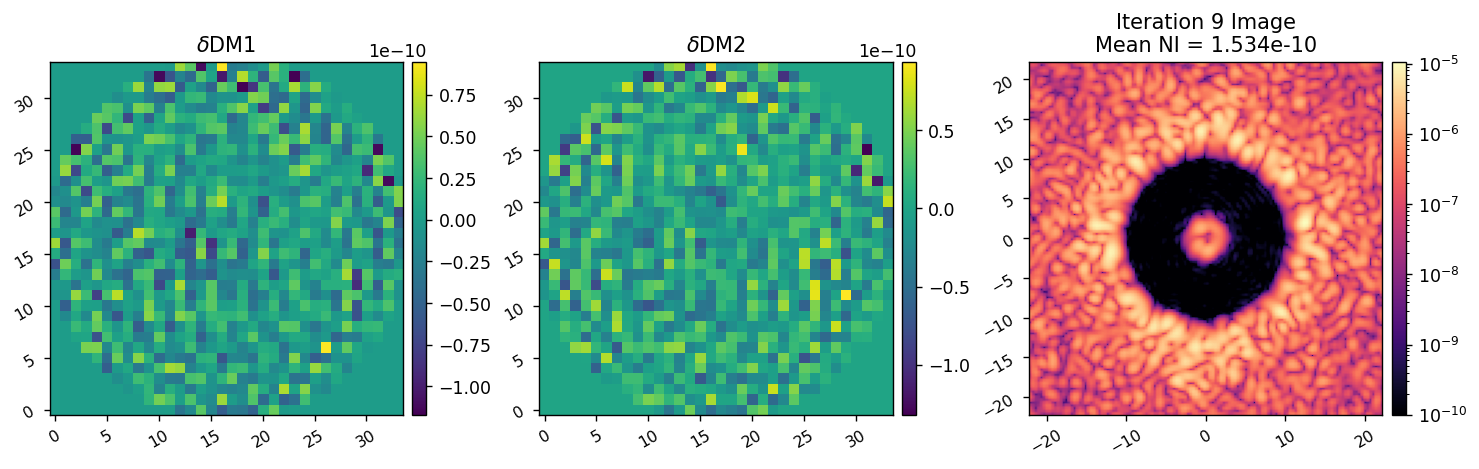

In [17]:
reload(fraunhofer)
reload(aefc)

r_cond = 1e-2
r_cond = 1e-3
# r_cond = 1e-4
# r_cond = 1e-5
# r_cond = 1e-7

bfgs_tol = 1e-2
bfgs_tol = 1e-3
# bfgs_tol = 1e-4
# bfgs_tol = 1e-5

bfgs_opts = {
    'maxiter':50,
    'disp':1,
    # 'ftol':1e-6,
    # 'gtol':1e-6,
}

data = aefc.run(
    I, 
    M, 
    fraunhofer.val_and_grad, 
    control_mask, 
    data,
    Nitr=3, 
    reg_cond=r_cond,
    bfgs_tol=bfgs_tol,
    bfgs_opts=bfgs_opts,
    gain=1,
)

In [17]:
utils.save_pickle('aefc_34_data.pkl', data)

Saved data to:  aefc_34_data.pkl


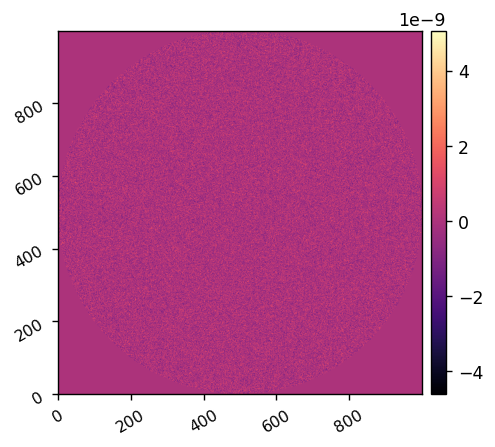

1.5692356715660787e-10


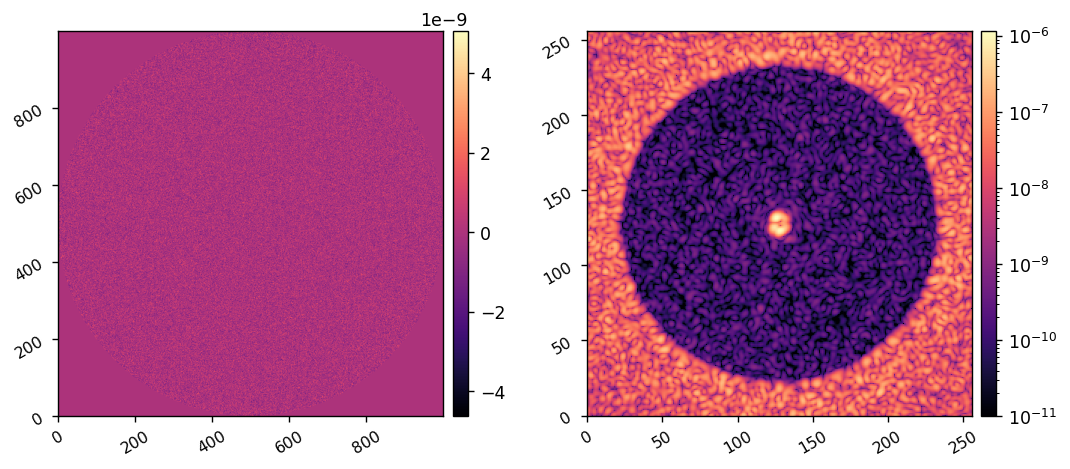

In [14]:
xp.random.seed(123)
rand_opd = 1e-9 * xp.random.randn(I.npix, I.npix) * I.BAP_MASK
imshow1(rand_opd)

I.WFE.opd = rand_opd

new_im = I.snap()
c = xp.mean(new_im[control_mask])
print(c)
imshow2(
    rand_opd, new_im,
    lognorm2=1, vmin2=1e-11,
)


In [39]:
Nopds = 10
Namps = 10
amps = xp.linspace(0, 5e-9, Namps)

contrasts = xp.zeros((Nopds,Namps))
for i in range(Nopds):
    xp.random.seed(123+i)
    rand_opd = xp.random.randn(I.npix, I.npix) * I.BAP_MASK
    for j in range(Namps):
        amp = amps[j]
        I.WFE.opd = amp * rand_opd

        new_im = I.snap()
        c = xp.mean(new_im[control_mask])
        print(c)

        contrasts[i,j] = c
    print()
        

2.241947611416599e-11
6.677196932074925e-11
1.9981557301240004e-10
4.2154782113534185e-10
7.319487353849503e-10
1.1309808415967357e-09
1.6185891931042573e-09
2.194701401047077e-09
2.859227671606123e-09
3.612060850140718e-09

2.241947611416599e-11
6.39383395716607e-11
1.8846554703847175e-10
3.960278287390694e-10
6.866372244210803e-10
1.0602910741561325e-09
1.516972015067684e-09
2.0566479839821505e-09
2.6792722259952065e-09
3.3847833089409657e-09

2.241947611416599e-11
6.623501348289605e-11
1.9730983270556435e-10
4.1559283344878957e-10
7.210186256249548e-10
1.1135075578304919e-09
1.5929657495097501e-09
2.1592851268294352e-09
2.812343462247443e-09
3.5520044177571763e-09

2.241947611416599e-11
6.273887952894249e-11
1.838482375938019e-10
3.856693939839919e-10
6.681108825648959e-10
1.0310679820924087e-09
1.4744227744705612e-09
1.998044206524164e-09
2.6017881552426697e-09
3.2854974964505265e-09

2.241947611416599e-11
6.335887369321221e-11
1.8614193296315628e-10
3.907215852191147e-10
6.7703483

In [40]:
mean_contrasts = xp.mean(contrasts, axis=0)

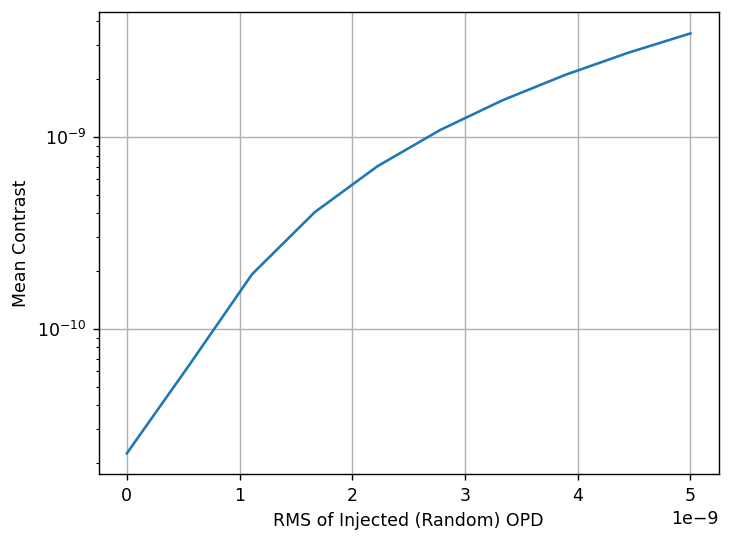

In [43]:
import matplotlib.pyplot as plt
plt.figure(dpi=125)
# plt.plot(ensure_np_array(amps), ensure_np_array(mean_contrasts))
plt.semilogy(ensure_np_array(amps), ensure_np_array(mean_contrasts))
plt.xlabel('RMS of Injected (Random) OPD')
plt.ylabel('Mean Contrast')
plt.grid()